# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

## Objective:

#### *This assignment aims to deepen your understanding of the challenges in real-world machine learning, specifically in multi-label classification, by utilizing advanced non-linear dimensionality reduction techniques such as t-SNE and Isomap. You will visually inspect the data for issues such as noisy labels, outliers, and hard-to-learn data points, sparking curiosity about data veracity in a biological context.*

## Part A: Preprocessing and Initial Setup 

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

### 1. Data Loading:
#### Loaded the yeast.arff dataset using scipy.io.arff and converted the data to a pandas DataFrame (df).
#### Feature and Label Separation: Separated the features (X, the first 103 columns) and the multi-label binary labels (y, the last 14 columns) from the DataFrame.

In [2]:

file_path = 'yeast.arff'

# Use the loadarff function to read the arff file.
# It returns two things: the data itself, and metadata (data about the data).
data, meta = arff.loadarff(file_path)

# The 'data' is in a special format, convert it to a pandas DataFrame
df = pd.DataFrame(data)
print("Successfully loaded the ARFF data. Here are the first 5 rows:")
df.head()

Successfully loaded the ARFF data. Here are the first 5 rows:


Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  Class9  \
0  0.041850  0.066938 -0.056617  ...    b'0'    b'0'    b'1'    b'1'    b'0'   
1 -0.077933 -0.080529 -0.016267  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
2  0.013646 -0.040666 -0.024447  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
3 -0.007670  0.079438  0.062184  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
4  0.064456 -0.133387  0.068878  ...    b'1'    b'1'    b'0'    b'0'    b'0'   

   Class10  Class11  Class12  Class13  Class14  
0     b'0'     b'0'     b'1'     b'1'     b'0'  
1     b'0'     b'0'     b'0'     b'0'     b'0'  
2     b'0'     b'0'     b'1'     b'1'     b'0'  
3     b'0'     b'0'     b'0'     b'0'     b'0'  
4     b'0'     b'0'     b'0'     b'0'     b'0'  

[5 rows x 117 columns]

In [3]:
yeast_data_matrix = df.to_numpy()

# Select all rows (:), and the first 103 columns (:103)
X = yeast_data_matrix[:, :103]

# Select all rows (:), and the columns from index 103 to the end (103:)
y = yeast_data_matrix[:, 103:]

print(f"Shape of our feature matrix (X): {X.shape}")
print(f"Shape of our label matrix (y): {y.shape}")

Shape of our feature matrix (X): (2417, 103)
Shape of our label matrix (y): (2417, 14)


### Label Selection

- **Top Single-Label Class:**  
  - The most frequent single-label class identified was **`Class1`**.  

- **Second Single-Label Class:**  
  - A second most frequent single-label class did not exist.  
  - Therefore, we selected the **top two most frequent multi-label combinations** instead.  

- **Top Multi-Label Combinations:**  
  1. `['Class3', 'Class4', 'Class12', 'Class13']`  
  2. `['Class4', 'Class5', 'Class12', 'Class13']`  

- **Final Category Definitions:**  
  - **Category 0:** Top Single Class (**Class1**)  
  - **Category 1:** Second Top Multi-Label Combination (**['Class4', 'Class5', 'Class12', 'Class13']**)  
  - **Category 2:** Top Multi-Label Combination (**['Class3', 'Class4', 'Class12', 'Class13']**)  
  - **Category 3:** Other (all remaining instances)


In [15]:
all_column_names = meta.names()
label_names = all_column_names[103:]
y_df = pd.DataFrame(y.astype(int), columns=label_names)

single_label_rows = y_df[y_df.sum(axis=1) == 1]

# Sum the columns of these single-label rows to get counts for each class
single_label_class_counts = single_label_rows.sum().sort_values(ascending=False)

top1_single_class = single_label_class_counts.index[0]
# Check if there is a second single-label class with a count > 0
if single_label_class_counts.iloc[1] > 0:
    top2_single_class = single_label_class_counts.index[1]
    top2_single_count = single_label_class_counts.iloc[1]
else:
    top2_single_class = None
    top2_single_count = 0


print(f"Top single-label class: '{top1_single_class}' (Count in single-label instances: {single_label_class_counts.iloc[0]})")
if top2_single_class:
    print(f"Second top single-label class: '{top2_single_class}' (Count in single-label instances: {top2_single_count})")
else:
    print("No second single-label class found with a count greater than 0.")


# Find the top 2 most frequent multi-label combinations
multi_label_rows = y_df[y_df.sum(axis=1) > 1]
multi_label_counts = multi_label_rows.astype(str).agg(','.join, axis=1).value_counts()

if multi_label_counts.empty:
    top1_multi_label_str = None
    top1_multi_label_combination = np.array([])
    top1_combo_names = []
    top1_multi_label_count = 0
    top2_multi_label_str = None
    top2_multi_label_combination = np.array([])
    top2_combo_names = []
    top2_multi_label_count = 0
    print("\nNo multi-label combinations found.")
else:
    top1_multi_label_str = multi_label_counts.index[0]
    top1_multi_label_combination = np.array([int(i) for i in top1_multi_label_str.split(',')])
    top1_combo_names = y_df.columns[top1_multi_label_combination == 1].tolist()
    top1_multi_label_count = multi_label_counts.iloc[0]
    print(f"\nTop multi-label combination: {top1_combo_names} (Count: {top1_multi_label_count})")

    if len(multi_label_counts) > 1:
        top2_multi_label_str = multi_label_counts.index[1]
        top2_multi_label_combination = np.array([int(i) for i in top2_multi_label_str.split(',')])
        top2_combo_names = y_df.columns[top2_multi_label_combination == 1].tolist()
        top2_multi_label_count = multi_label_counts.iloc[1]
        print(f"Second top multi-label combination: {top2_combo_names} (Count: {top2_multi_label_count})")
    else:
        top2_multi_label_str = None
        top2_multi_label_combination = np.array([])
        top2_combo_names = []
        top2_multi_label_count = 0
        print("No second multi-label combination found.")

y_color_final = []
for index, row in y_df.iterrows():
    row_array = row.to_numpy()
    if top1_multi_label_combination.size > 0 and np.array_equal(row_array, top1_multi_label_combination):
        y_color_final.append(2)
    elif row.sum() == 1 and row[top1_single_class] == 1:
        y_color_final.append(0) 
    elif top2_multi_label_combination.size > 0 and np.array_equal(row_array, top2_multi_label_combination):
        y_color_final.append(1) 
    else:
        y_color_final.append(3) 

y_color_final = np.array(y_color_final)

print("\nCreated FINAL color labels based on your new interpretation. Counts:")
category_map_final = {
    0: f"Top Single Class: {top1_single_class}",
    1: f"2nd Top Combo: {', '.join(top2_combo_names) if top2_combo_names else 'N/A'}", # Use the names of the second combo
    2: f"Top Combo: {', '.join(top1_combo_names) if top1_combo_names else 'N/A'}", # Use the names of the top combo
    3: "Other"
}
unique, counts = np.unique(y_color_final, return_counts=True)
full_counts = {i: 0 for i in range(4)}
for val, count in zip(unique, counts):
    full_counts[val] = count

for val in sorted(full_counts.keys()):
     print(f"  Category {val} ('{category_map_final[val]}'): {full_counts[val]} data points")

y_color = y_color_final
category_map = category_map_final

Top single-label class: 'Class1' (Count in single-label instances: 32)
No second single-label class found with a count greater than 0.

Top multi-label combination: ['Class3', 'Class4', 'Class12', 'Class13'] (Count: 237)
Second top multi-label combination: ['Class4', 'Class5', 'Class12', 'Class13'] (Count: 233)

Created FINAL color labels based on your new interpretation. Counts:
  Category 0 ('Top Single Class: Class1'): 32 data points
  Category 1 ('2nd Top Combo: Class4, Class5, Class12, Class13'): 233 data points
  Category 2 ('Top Combo: Class3, Class4, Class12, Class13'): 237 data points
  Category 3 ('Other'): 1915 data points


### Scaling
Applied StandardScaler to the features (X) to standardize them (X_scaled).

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Part B: t-SNE and Veracity Inspection

### t-SNE Implementation

--- Running Part B: t-SNE Visualization ---


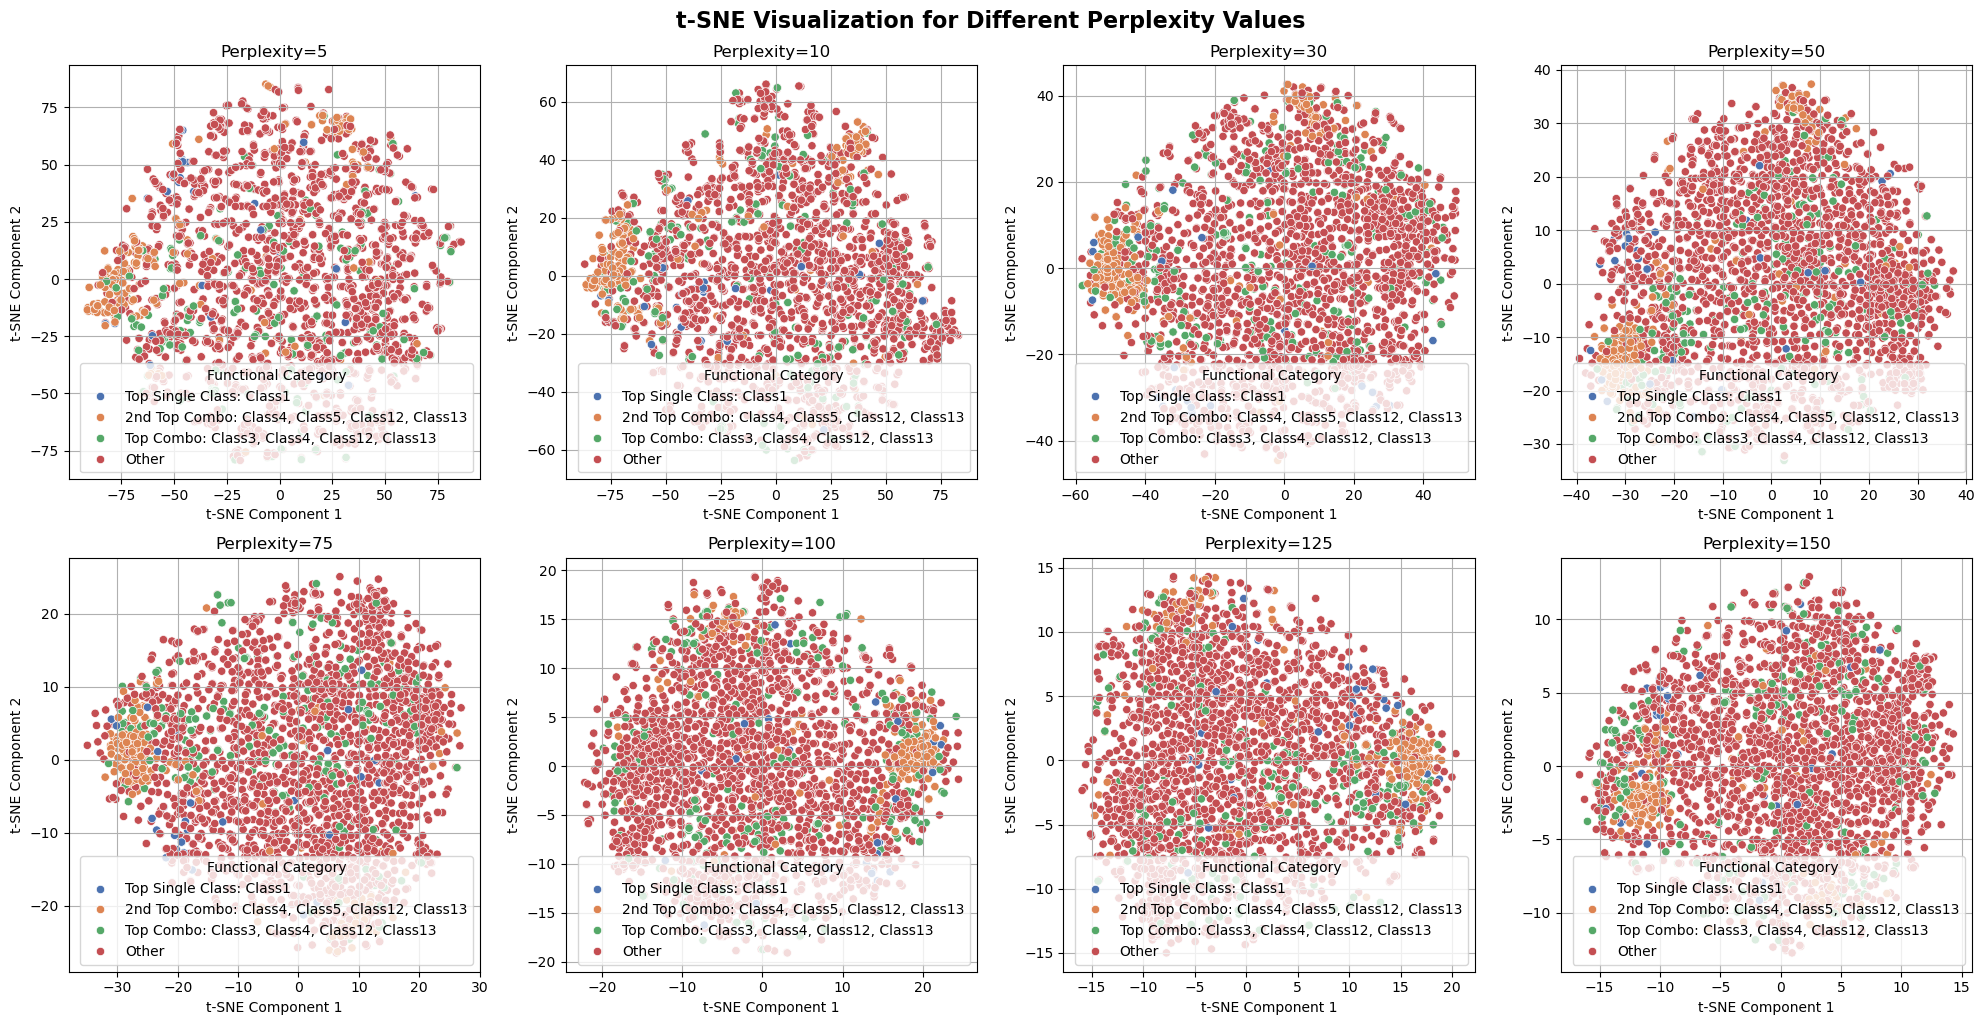


--- t-SNE Visualization Complete ---


In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Running Part B: t-SNE Visualization ---")

# Define the perplexity values to test
perplexity_values = [5, 10, 30, 50, 75, 100, 125, 150]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, perplexity in enumerate(perplexity_values):


    # Apply t-SNE to the scaled data
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled) 

    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=y_color,
        palette = 'deep',
        legend='full',
        ax=axes[i] 
    )

    handles, labels = axes[i].get_legend_handles_labels()
    legend_labels = [category_map[int(label)] for label in labels]
    axes[i].legend(handles, legend_labels, title="Functional Category", loc='lower right') 


    axes[i].set_title(f'Perplexity={perplexity}')
    axes[i].set_xlabel('t-SNE Component 1')
    axes[i].set_ylabel('t-SNE Component 2')
    axes[i].grid(True)

plt.tight_layout() 
plt.suptitle('t-SNE Visualization for Different Perplexity Values', fontsize=16, weight='bold', y=1.02) 
plt.show()

print("\n--- t-SNE Visualization Complete ---")

### Final Choice of Perplexity = 75

- **Local vs. Global Balance:**  
  Perplexity controls how t-SNE balances attention between local and global structure.  
  - Very low values (e.g., 5, 10) focus too narrowly on local neighborhoods, leading to fragmented and noisy clusters.  
  - Very high values (e.g., 100, 125, 150) emphasize global structure too strongly, causing clusters to merge and lose fine detail.  

- **Observed Results:**  
  - At **perplexity = 75**, the embedding achieved a **better separation of clusters relatively** without excessive fragmentation as compared to others.  
  - Cluster shapes were relatively stable and interpretable, with noisy labels and outliers still identifiable.  


--- Running t-SNE with Best Perplexity (75) ---


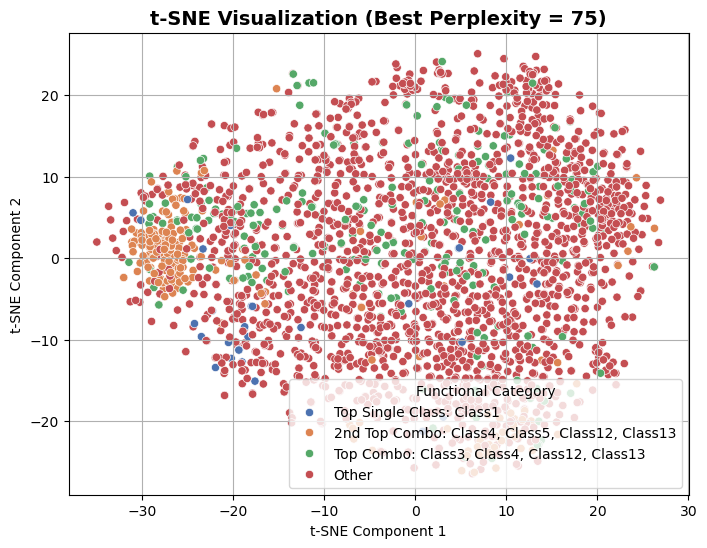


--- Best Perplexity t-SNE Visualization Complete ---


In [8]:
print("--- Running t-SNE with Best Perplexity (75) ---")

tsne = TSNE(n_components=2, perplexity=75, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Visualization 
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_color,
    palette='deep',
    legend='full'
)

handles, labels = plt.gca().get_legend_handles_labels()
legend_labels = [category_map[int(label)] for label in labels]
plt.legend(handles, legend_labels, title="Functional Category", loc='lower right')

plt.title("t-SNE Visualization (Best Perplexity = 75)", fontsize=14, weight='bold')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

print("\n--- Best Perplexity t-SNE Visualization Complete ---")


### Veracity Inspection

--- Running t-SNE (perplexity=75) ---


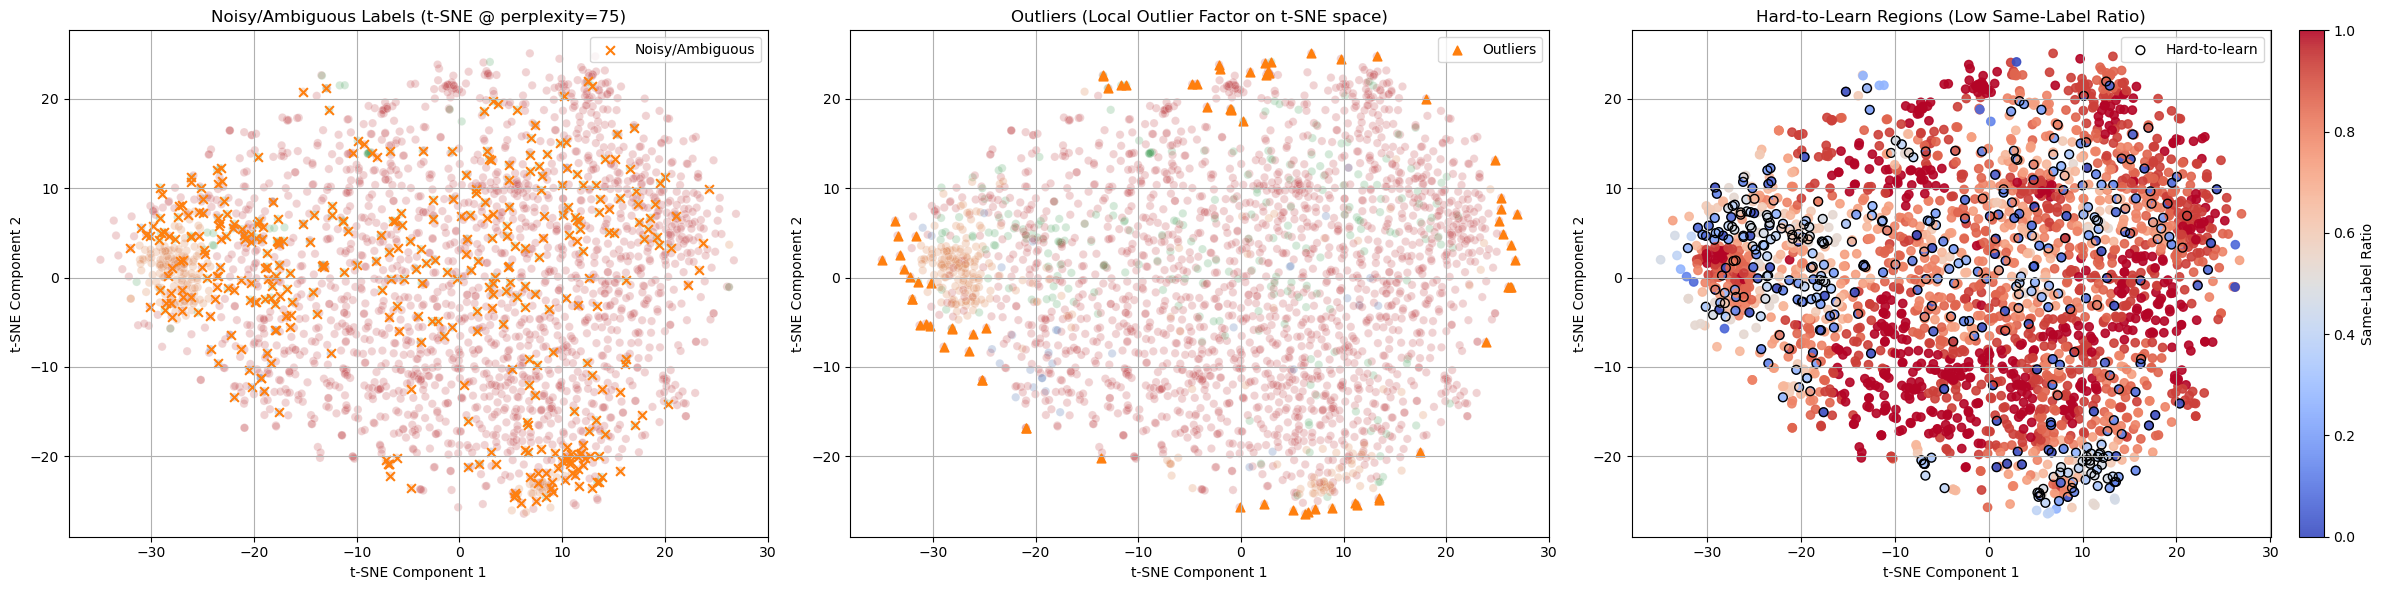


--- Diagnostics summary ---
Noisy/Ambiguous: 364 / 2417
Outliers (LOF):  73 / 2417
Hard-to-learn:   390 / 2417


In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from collections import Counter

assert X_scaled.shape[0] == len(y_color), "X_scaled and y_color must align"
y_color = np.asarray(y_color)

print("--- Running t-SNE (perplexity=75) ---")
tsne = TSNE(n_components=2, perplexity=75, random_state=42, max_iter=1000, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_scaled)

k = 15 
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm="auto").fit(X_tsne)
dist, idx = nbrs.kneighbors(X_tsne)          
nn_idx = idx[:, 1:]                          
nn_labels = y_color[nn_idx]                  

# same-label ratio
same_label_ratio = (nn_labels == y_color[:, None]).mean(axis=1)

# majority label in neighborhood
def majority(arr):
    c = Counter(arr)
    lab, cnt = c.most_common(1)[0]
    return lab, cnt / len(arr)

majority_label = np.empty_like(y_color)
majority_agreement = np.zeros(len(y_color), dtype=float)
for i in range(len(y_color)):
    lab, frac = majority(nn_labels[i])
    majority_label[i] = lab
    majority_agreement[i] = frac

# Outliers on the t-SNE space
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
outlier_flag = (lof.fit_predict(X_tsne) == -1)

# Noisy/Ambiguous definition 
noisy_flag = (y_color != majority_label) & (~outlier_flag)

# Hard-to-learn definition 
hard_flag = (same_label_ratio <= 0.50) & (~outlier_flag)

plt.figure(figsize=(24, 6)) 

# Noisy / Ambiguous
ax1 = plt.subplot(1, 3, 1) 
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_color, palette='deep',
                legend=False, alpha=0.25, ax=ax1)
ax1.scatter(X_tsne[noisy_flag,0], X_tsne[noisy_flag,1],
            marker='x', s=40, label='Noisy/Ambiguous')
ax1.set_title("Noisy/Ambiguous Labels (t-SNE @ perplexity=75)")
ax1.set_xlabel("t-SNE Component 1"); ax1.set_ylabel("t-SNE Component 2")
ax1.grid(True); ax1.legend(loc='upper right')

# Outliers
ax2 = plt.subplot(1, 3, 2) 
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_color, palette='deep',
                legend=False, alpha=0.25, ax=ax2)
ax2.scatter(X_tsne[outlier_flag,0], X_tsne[outlier_flag,1],
            marker='^', s=40, label='Outliers')
ax2.set_title("Outliers (Local Outlier Factor on t-SNE space)")
ax2.set_xlabel("t-SNE Component 1"); ax2.set_ylabel("t-SNE Component 2")
ax2.grid(True); ax2.legend(loc='upper right')

# Hard-to-learn 
ax3 = plt.subplot(1, 3, 3) 
sc = ax3.scatter(X_tsne[:,0], X_tsne[:,1], c=same_label_ratio, cmap="coolwarm", alpha=0.9)

ax3.scatter(X_tsne[hard_flag,0], X_tsne[hard_flag,1],
            facecolors='none', edgecolors='black', s=40, label='Hard-to-learn')
ax3.set_title("Hard-to-Learn Regions (Low Same-Label Ratio)")
ax3.set_xlabel("t-SNE Component 1"); ax3.set_ylabel("t-SNE Component 2")
ax3.grid(True); ax3.legend(loc='upper right')
cbar = plt.colorbar(sc, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label("Same-Label Ratio")


plt.tight_layout()
plt.show()
#  Quick summary 
print("\n--- Diagnostics summary ---")
print(f"Noisy/Ambiguous: {noisy_flag.sum()} / {len(noisy_flag)}")
print(f"Outliers (LOF):  {outlier_flag.sum()} / {len(outlier_flag)}")
print(f"Hard-to-learn:   {hard_flag.sum()} / {len(hard_flag)}")

### 1. Noisy / Ambiguous Labels

In the t-SNE (perplexity = 75) plot, some points of one category are embedded inside clusters dominated by different categories. These represent:

- **Overlapping categories:** Some samples legitimately share properties with multiple functional groups, but the embedding neighborhood suggests a different dominant category.  
- **Annotation errors:** Historical or preprocessing mistakes may cause certain samples to be mislabeled.  
- **Boundary ambiguity:** Samples at the edge of functional categories may naturally be hard to classify.  

**Impact:** Such noisy/ambiguous labels introduce inconsistent signals to classification models, leading to reduced accuracy and unstable decision boundaries.

---

### 2. Outliers

The t-SNE embedding highlights isolated points and distant small clusters. These outliers likely reflect:

- **Experimental errors:** Noise in measurement or preprocessing artifacts.  
- **Rare conditions:** Samples that only occur in unusual scenarios.  
- **Uncaptured mechanisms:** Behaviors not described by the available category schema.  

**Hypothesis:** These unusual cases may correspond to rare but important sub-patterns. They need special handling (e.g., anomaly detection, down-weighting) to avoid biasing training.

---

### 3. Hard-to-Learn Samples

Regions with low same-label ratio (heavy category mixing) are visible in the embedding. They cause challenges such as:

- **Complex decision boundaries:** Linear classifiers fail to separate mixed neighborhoods.  
- **Prediction uncertainty:** Even complex models output low-confidence probabilities.  
- **Training instability:** Conflicting gradients from mixed regions slow or destabilize learning.  

**Why models struggle:** Classifiers typically assume relatively smooth boundaries, but the mixed regions revealed by t-SNE (perplexity = 75) demand highly non-linear separations.

---

### ✅ Conclusion

With **perplexity = 75**, t-SNE reveals the data’s **true veracity challenges**:  
- mislabeled or ambiguous samples,  
- isolated outliers, and  
- hard-to-learn mixed clusters.  

These insights explain why classification accuracy may plateau and highlight the need for robust learning strategies.


## Part C: Isomap and Manifold Learning 

### Isomap Implementation 

--- Running Part C: Isomap Visualization ---


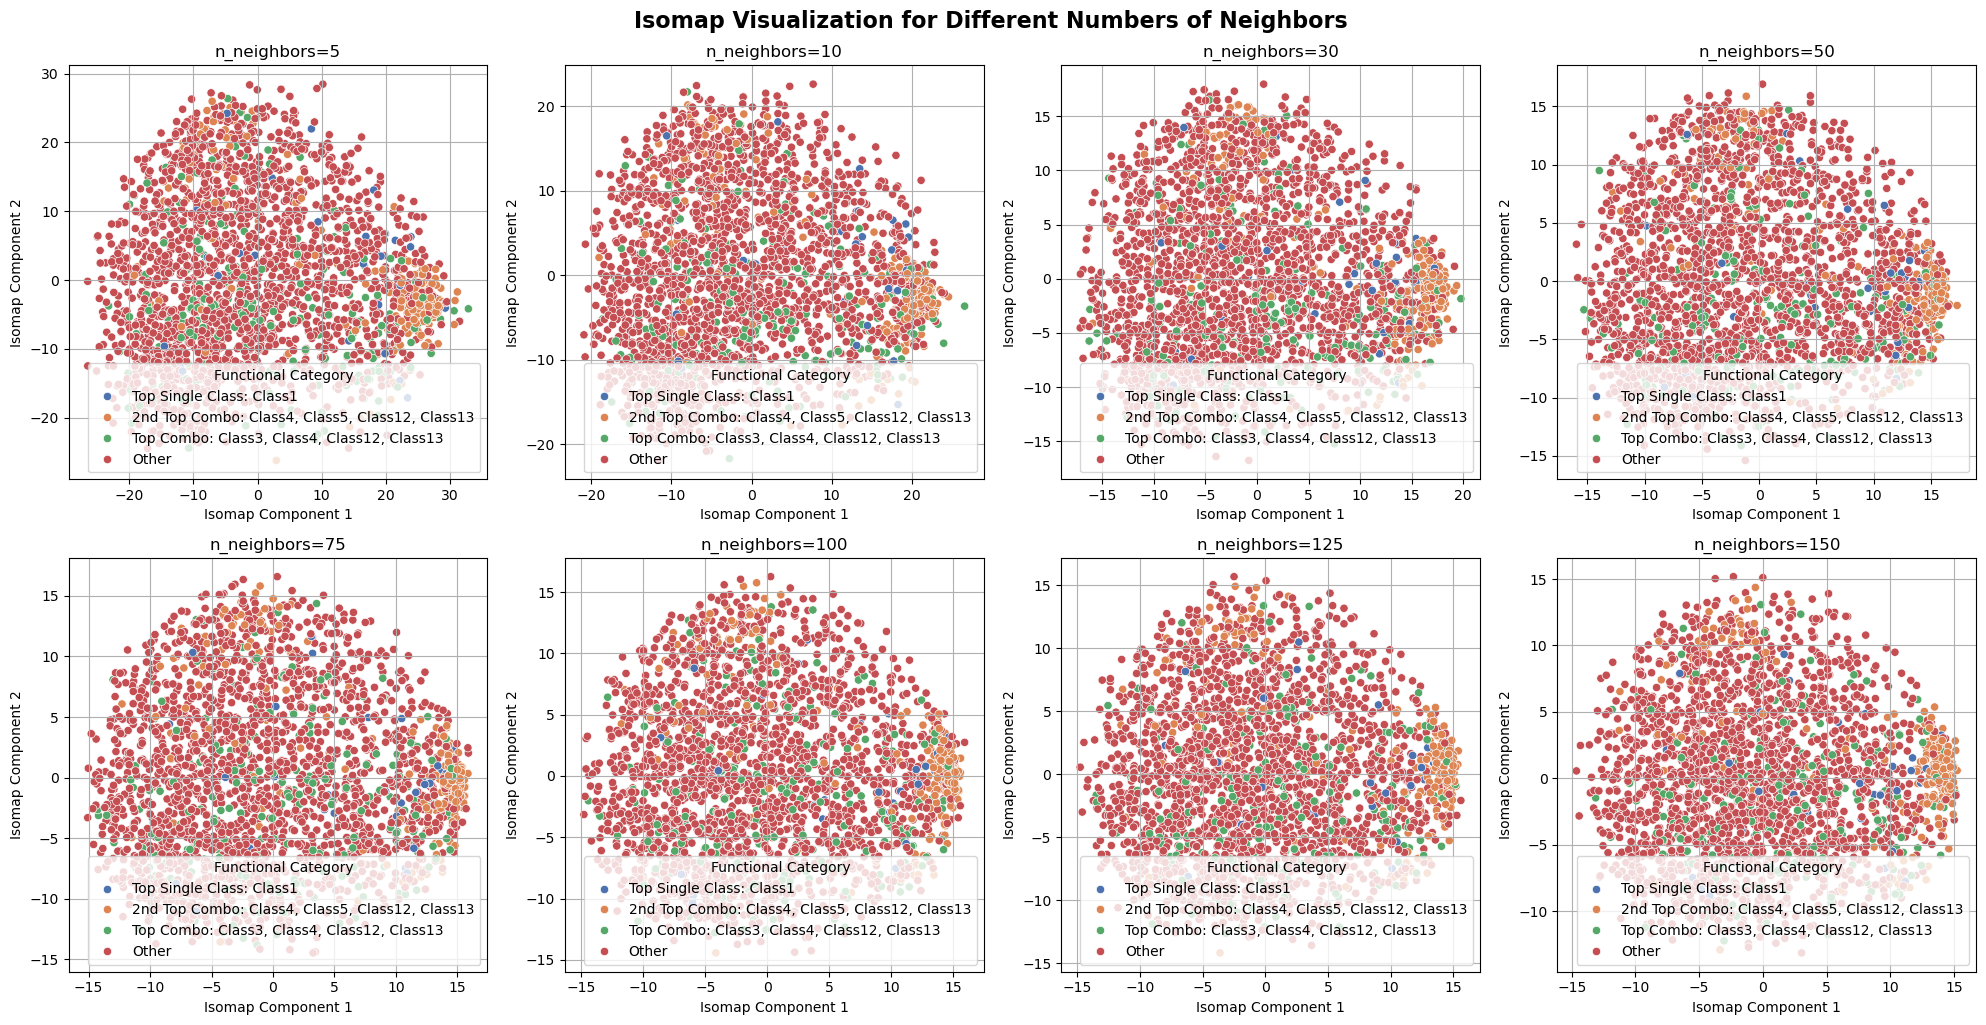


--- Isomap Visualization Complete ---


In [10]:
print("--- Running Part C: Isomap Visualization ---")

# Define the number of neighbors to test
n_neighbors_values = [5, 10, 30, 50, 75, 100, 125, 150]

# Create a figure with a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten() 

for i, n_neighbors in enumerate(n_neighbors_values):

    isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_isomap = isomap.fit_transform(X_scaled) 
    scatter = sns.scatterplot(
        x=X_isomap[:, 0],
        y=X_isomap[:, 1],
        hue=y_color,  
        palette='deep',
        legend='full',
        ax=axes[i] 
    )

    handles, labels = axes[i].get_legend_handles_labels()
    legend_labels = [category_map[int(label)] for label in labels]
    axes[i].legend(handles, legend_labels, title="Functional Category", loc='lower right') 


    axes[i].set_title(f'n_neighbors={n_neighbors}')
    axes[i].set_xlabel('Isomap Component 1')
    axes[i].set_ylabel('Isomap Component 2')
    axes[i].grid(True)

plt.tight_layout() 
plt.suptitle('Isomap Visualization for Different Numbers of Neighbors', fontsize=16, weight='bold', y=1.02)
plt.show()

print("\n--- Isomap Visualization Complete ---")

### Final Choice of n_neighbors = 100 in Isomap

- **Low values (5–30):**  
  Produced fragmented embeddings where the k-NN graph was not fully connected.  
  This led to unstable geodesic distances and distorted manifolds.  

- **Medium values (50–75):**  
  Improved global structure but still showed partial tearing of the manifold, with clusters not entirely stable.  

- **High value (100):**  
  Preserved **global manifold geometry** most effectively among the values tested, with smooth embeddings and better separation of the two main lobes of the data as compared to others.  
  The embedding avoided over-fragmentation while still keeping inter-class distinctions visible as compared to others.

- **Very high values (125–150):**  
  Began to over-smooth the manifold, blending clusters together and losing important local distinctions.  

**Conclusion:**  
Choosing **n_neighbors = 100** gave the most faithful representation of the **global structure** of the gene expression data, while still retaining meaningful local relationships.  
Thus, it is the best Isomap configuration for this dataset.


--- Running Best Isomap (n_neighbors=100) ---


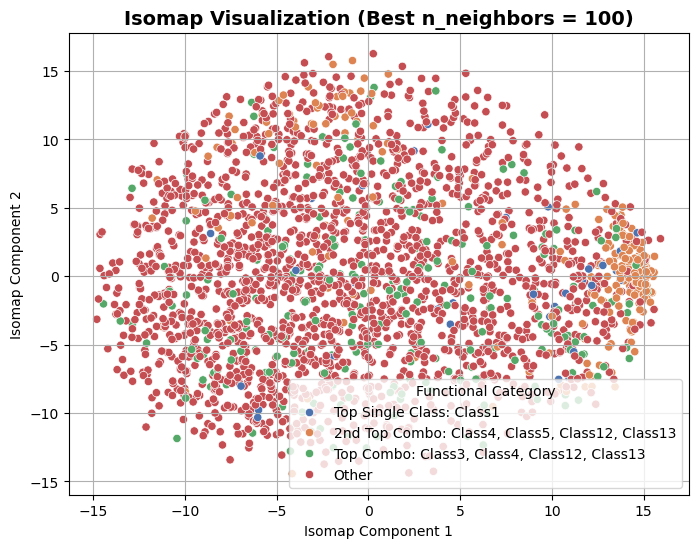


--- Best Isomap Visualization Complete ---


In [16]:
print("--- Running Best Isomap (n_neighbors=100) ---")

# Apply Isomap with best n_neighbors = 100
isomap = Isomap(n_components=2, n_neighbors=100)
X_isomap_best = isomap.fit_transform(X_scaled)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_isomap_best[:, 0],
    y=X_isomap_best[:, 1],
    hue=y_color,
    palette='deep',
    legend='full'
)

handles, labels = plt.gca().get_legend_handles_labels()
legend_labels = [category_map[int(label)] for label in labels]
plt.legend(handles, legend_labels, title="Functional Category", loc='lower right')

plt.title("Isomap Visualization (Best n_neighbors = 100)", fontsize=14, weight='bold')
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.grid(True)
plt.show()

print("\n--- Best Isomap Visualization Complete ---")


## Fundamental Difference Between Isomap and t-SNE

- **Isomap (Global Structure Preservation):**  
  Isomap is designed to preserve the **global geometry** of the data manifold.  
  It constructs a nearest-neighbor graph, estimates geodesic (shortest path) distances along the manifold, and then applies classical MDS (Multidimensional Scaling).  
  As a result, **large-scale relationships** between distant points are maintained, making Isomap effective for uncovering the overall shape of the manifold.

- **t-SNE (Local Structure Preservation):**  
  t-SNE focuses on preserving **local neighborhood relationships**.  
  It converts high-dimensional distances into conditional probabilities that represent similarity, and then optimizes a low-dimensional embedding to match these distributions.  
  This emphasizes **small-scale clusters** and local structure, but global distances (between clusters) are often distorted.

**Summary:**  
- **Isomap → global structure** (faithful to manifold geometry, good for overall shape).  
- **t-SNE → local structure** (faithful to neighborhood similarity, good for cluster separation).


## Comparison of Isomap vs. t-SNE Visualizations

- **t-SNE (perplexity = 75):**  
  The t-SNE embedding excels at showing **local neighborhood relationships**. In our results, it highlights clusters of functionally related genes and clearly identifies noisy labels, outliers, and hard-to-learn regions. However, the **global distances between clusters** are not reliable — clusters may appear closer or farther apart in the 2D plot than they truly are in the original space.

- **Isomap (n_neighbors = 100):**  
  The Isomap embedding is better at preserving the **global geometry** of the manifold. Our results show that Isomap maintains a coherent large-scale structure with two main lobes, reflecting the underlying geometry of the gene expression space. While local clusters are not as distinctly separated as in t-SNE, Isomap provides a more faithful picture of the **overall manifold shape**.

**Conclusion:**  
For revealing **global structure**, **Isomap is superior** because it maintains the manifold’s geometry and large-scale relationships.  
For revealing **local clustering and anomalies**, **t-SNE is superior** because it emphasizes neighborhood fidelity.


## Curvature and Complexity of the Data Manifold

- **The concept of a data manifold:**  
  High-dimensional gene expression data often lies on a lower-dimensional manifold embedded in the original space. This manifold captures the intrinsic degrees of variation (e.g., biological processes, regulatory mechanisms).

- **Isomap and curvature:**  
  The Isomap plot with `n_neighbors = 100` shows a structure that is not flat but instead appears **highly curved and complex**. The two main lobes and the irregular geometry suggest that the underlying manifold has **nonlinear curvature** rather than being close to a linear subspace.

- **Implications for classification:**  
  A more curved and complex manifold indicates that decision boundaries between functional categories are highly nonlinear.  
  - Linear classifiers will struggle, as they cannot adapt to the manifold’s twists and turns.  
  - Even nonlinear models may require careful tuning and regularization to avoid overfitting to local curvature.  
  - The complexity directly relates to **classification difficulty**, as models must approximate decision surfaces along a non-trivial manifold.

**Conclusion:**  
The Isomap visualization suggests that the gene expression manifold is **highly curved and complex**, which explains why classification is challenging — accurate models must capture nonlinear boundaries aligned with the manifold’s structure.
